## ewf-ext-02-03-02 - NDVI growing season statistics time series per pixel

NDVI growing season statistics time series per pixel

---

### <a name="service">Service definition

In [1]:
service = dict([('title', 'NDVI growing season statistics time series per pixel'),
                ('abstract', 'NDVI growing season statistics time series per pixel'),
                ('id', 'ewf-ext-02-03-02')])

### <a name="parameter">Parameter Definition 

In [2]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [3]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'P001'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

In [4]:
ndviIndex = dict([('id', 'ndviIndex'),
             ('value', 'better-ext-02-03-01'),
             ('title', 'ndvi catalog index'),
             ('abstract', 'index to access ndvi catalog'),
             ('minOccurs', '1')])

In [5]:
ndviApikey = dict([('id', 'ndviApikey'),
                ('value', ''),
                ('title', 'ndvi catalog apikey'),
                ('abstract', 'apikey to access ndvi catalog'),
                ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the NDVI stack of products' identifiers

In [6]:
# 2014, 2015, 2016, 2017
#input_identifiers = ('LE07_L1TP_204033_20140311_20161117_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140428_20161116_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140514_20161115_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140530_20161115_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140615_20161113_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140701_20161112_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140717_20161112_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140818_20161111_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20141208_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20141224_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150109_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150125_20161029_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150314_20161028_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150330_20161028_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150517_20161026_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150602_20161025_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150618_20161025_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150704_20161024_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150720_20161027_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150805_20161023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150821_20161022_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150922_20161019_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151008_20161018_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151109_20161017_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151227_20161016_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160112_20161015_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160229_20161014_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160401_20161013_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160503_20161011_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160519_20161010_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160620_20161209_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160706_20161009_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160722_20161010_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160807_20161008_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160823_20161007_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160908_20161006_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160924_20161023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161026_20161121_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161127_20170118_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161229_20170219_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170114_20170209_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170319_20170414_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170404_20170430_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170420_20170516_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170506_20170601_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170522_20170617_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170607_20170703_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170623_20170719_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170709_20170804_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170725_20170820_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170810_20170905_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170826_20170921_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170911_20171007_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170927_20171023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171013_20171110_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171029_20171124_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171114_20171210_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171130_20171226_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171216_20180111_01_T1_sr_NDVI.tif')

# 2014
#input_identifiers = ('LE07_L1TP_204033_20140311_20161117_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140428_20161116_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140514_20161115_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140530_20161115_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140615_20161113_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140701_20161112_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140717_20161112_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20140818_20161111_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20141208_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20141224_20161030_01_T1_sr_NDVI.tif')

# 2015
#input_identifiers = ('LE07_L1TP_204033_20150109_20161030_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150125_20161029_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150314_20161028_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150330_20161028_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150517_20161026_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150602_20161025_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150618_20161025_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150704_20161024_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150720_20161027_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150805_20161023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150821_20161022_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20150922_20161019_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151008_20161018_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151109_20161017_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20151227_20161016_01_T1_sr_NDVI.tif')

# 2016
#input_identifiers = ('LE07_L1TP_204033_20160112_20161015_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160229_20161014_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160401_20161013_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160503_20161011_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160519_20161010_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160620_20161209_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160706_20161009_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160722_20161010_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160807_20161008_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160823_20161007_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160908_20161006_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20160924_20161023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161026_20161121_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161127_20170118_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20161229_20170219_01_T1_sr_NDVI.tif')

# 2017
#input_identifiers = ('LE07_L1TP_204033_20170114_20170209_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170319_20170414_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170404_20170430_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170420_20170516_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170506_20170601_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170522_20170617_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170607_20170703_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170623_20170719_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170709_20170804_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170725_20170820_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170810_20170905_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170826_20170921_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170911_20171007_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20170927_20171023_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171013_20171110_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171029_20171124_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171114_20171210_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171130_20171226_01_T1_sr_NDVI.tif','LE07_L1TP_204033_20171216_20180111_01_T1_sr_NDVI.tif')


#input_identifiers = ('LE07_L1TP_204033_20140311_20161117_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140428_20161116_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140514_20161115_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140530_20161115_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140615_20161113_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140701_20161112_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140717_20161112_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140818_20161111_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20141208_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20141224_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150109_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150125_20161029_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150314_20161028_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150330_20161028_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150517_20161026_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150602_20161025_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150618_20161025_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150704_20161024_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150720_20161027_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150805_20161023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150821_20161022_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150922_20161019_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151008_20161018_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151109_20161017_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151227_20161016_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160112_20161015_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160229_20161014_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160401_20161013_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160503_20161011_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160519_20161010_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160620_20161209_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160706_20161009_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160722_20161010_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160807_20161008_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160823_20161007_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160908_20161006_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160924_20161023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161026_20161121_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161127_20170118_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161229_20170219_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170114_20170209_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170319_20170414_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170404_20170430_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170420_20170516_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170506_20170601_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170522_20170617_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170607_20170703_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170623_20170719_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170709_20170804_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170725_20170820_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170810_20170905_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170826_20170921_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170911_20171007_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170927_20171023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171013_20171110_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171029_20171124_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171114_20171210_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171130_20171226_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171216_20180111_01_T1_sr_P001_NDVI.tif')




# 2014
#input_identifiers = ('LE07_L1TP_204033_20140311_20161117_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140428_20161116_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140514_20161115_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140530_20161115_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140615_20161113_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140701_20161112_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140717_20161112_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20140818_20161111_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20141208_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20141224_20161030_01_T1_sr_P001_NDVI.tif')

# 2015
#input_identifiers = ('LE07_L1TP_204033_20150109_20161030_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150125_20161029_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150314_20161028_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150330_20161028_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150517_20161026_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150602_20161025_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150618_20161025_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150704_20161024_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150720_20161027_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150805_20161023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150821_20161022_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20150922_20161019_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151008_20161018_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151109_20161017_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20151227_20161016_01_T1_sr_P001_NDVI.tif')

#input_identifiers = ('0CFC36158132DA794782B428E6DF76E7DC4C07CD', '4F49AF0E4B772965258B1AD001423D60228BB49A', '82A433CFFE0F4115F8A4BBFFDCB1C3D6A5709427', '487C80B2EF22D66AB8F10F65A7CBD6BAFB3E3939', '87E43FB9A02BE617A7A731DDD668B661B6EBCE07', '03F1348D9DCDC9A1E1A2B544E76C92420E70A31A', 'C72F7439E9A8853E8D64B44E52A0D24CF797F6E6', '164BB5EE04E403530B3C87F0ECDF4E95C54188B8', '1E44F63186475D883CDB9FED5E2ACB8CA992A9DF', '01D316DE31BAD714AF0F9B0CFCEED5E7697BC09F', '0E314958DD97CF88FF11F81147CE52AF3FD13B4A', 'C812DC63D58400C16515C79F8C4BCA32332B2724', 'B8EF89460AF0FE1344881FBEF5E533371BD6C404', 'A27CAA804DDA8A3B9256D1E4B9E080031E6BEBCD', '2DA8C200ABE9599DD7D5BDB155B0BE1922E2F139')

# 2016
##input_identifiers = ('LE07_L1TP_204033_20160112_20161015_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160229_20161014_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160401_20161013_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160503_20161011_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160519_20161010_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160620_20161209_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160706_20161009_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160722_20161010_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160807_20161008_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160823_20161007_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160908_20161006_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20160924_20161023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161026_20161121_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161127_20170118_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20161229_20170219_01_T1_sr_P001_NDVI.tif')

input_identifiers = ('496D00DB33D88356DAE2C344516FD5D699C1F5DE', 'B073C856BA5FD6453B08C04527FFB95DA622FFC1', '1067AFC0B24F69C2050F093DE7F110E4419174F4', 'C438B6CB4131CEBFF6741926B03B7E137641AF4C', '9C2C13C121F71803FC1E697C306C9603B6680303', 'E74B265D5CF4626BF6F360B6379D409AA5D3B8A8', '83F48D641924F90544ED66C701B36BF0E65153C8', 'F3FD3FF45ECC114A665F6C239F6812DE7786A98F', '952AC4BFAB859E9F68762A61D206D690726AF431', 'B726A411FF02675367B07D82059B2E0945C1F3DA', 'D4DFDC63732D33DB14B9E7B3D34D5BF732547F6F', '8F51A4ED9AB3DB6DC5920B06382817C28C2D1A3B', 'E21111899ECFAF1AA5A991D625B2F00BE68024E3', '944CC689671685BC84E5DBBF95A12E0825B85C81', 'A1A83855BF03D91480273FE5C32D1AA33BB77715')

# 2017
##input_identifiers = ('LE07_L1TP_204033_20170114_20170209_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170319_20170414_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170404_20170430_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170420_20170516_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170506_20170601_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170522_20170617_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170607_20170703_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170623_20170719_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170709_20170804_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170725_20170820_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170810_20170905_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170826_20170921_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170911_20171007_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20170927_20171023_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171013_20171110_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171029_20171124_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171114_20171210_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171130_20171226_01_T1_sr_P001_NDVI.tif','LE07_L1TP_204033_20171216_20180111_01_T1_sr_P001_NDVI.tif')

#input_identifiers = ('23CFAEB3EABC76DEB761059E5358AAAA7E6B73C0', '8413BCE5866586CFA8C228F42F4A0857689C20CF', '1559F9C271D8D9133AED47EFB4F253B3E8214701', 'C8D85D9F1D4BFCBC2132F878802D28400E42D35D', 'E8EA192CE196DA08137D8C3D99D5613F51DBB4F6', 'CDED3F2A35002477AC57692830E1D68D066ED4D2', '272816AC6E6E655F0F7247C7C9DA7608B2408893', 'C4F69F8C3AEA1C2C958AB0F97A4D85DCF9CB96CB', 'FED212ED127A33D5B06F95ABD582DAB981C82772', '945E4464682095D6DB964AF430BD53357D54E140', 'FC482A14CE3A63BBDF1CBF591AD9F9E2ECFF58E7', '6B5834E426558BF0F5D167D164C6F1F5EE1D0FFD', '73288D3159115BF7AAEAA049F023340691C0E121', 'D6D4200A3247562D2EA893F23E6B9DB36FA87687', 'A391B46EAEA2CC4E32207B8909B5E991EBFD96E0', 'F3FDC848CD9781ADCF2D85A611ED40CE7E23F454', '6D5DED33A75AF7793F2D62E15692962085730DD9', '62499DA2F0E79F68B86692B468503FD8D9FFDBA2', '07CE2DB5EEE4121950D91543518D4C9A69ED504E')


**Input references**

This is the NDVI stack catalogue references

In [7]:
input_references = tuple(['https://catalog.terradue.com/better-ext-02-03-01/search?format=atom&uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [8]:
data_path = "/workspace/dev/ewf-ext-02-03-01/src/main/app-resources/notebook/libexec"
data_path = "/workspace/dev/ewf-ext-02-03-01/src/main/app-resources/notebook/libexec/parcel"

**Aux folders**

In [9]:
output_folder = ''

In [10]:
temp_folder = 'temp'

#### Import Modules

In [11]:
import os
import shutil

import sys
import string
import numpy as np
import numpy.ma as ma
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import matplotlib
import matplotlib.pyplot as plt

import scipy.signal

import datetime

import pdb


sys.path.append(os.getcwd())
sys.path.append('/application/notebook/libexec/')
from s2_whittaker_helpers import *
from whittaker import ws2d, ws2doptv, ws2doptvp
import array

import pandas as pd
import geopandas as gpd

import cioppy
ciop = cioppy.Cioppy()

#### Auxiliary vars

In [12]:
check_results = True

#### Auxiliary methods

In [13]:
# remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            

def get_input_metadata (input_refs):
    
    # for each product get metadata
    Result_Prod = []
    
    for index,product_ref in enumerate(input_refs):
        
        # since the search is by identifier 
        Result_Prod.append(ciop.search(end_point = product_ref,params =[],output_fields='self,identifier,startdate,enclosure,startdate,enddate,wkt,title',creds='{}:{}'.format(ndviIndex['value'],ndviApikey['value']))[0] )
    

    input_metadata = gpd.GeoDataFrame.from_dict(Result_Prod)

    input_metadata['startdate'] = pd.to_datetime(input_metadata['startdate'])
    input_metadata['enddate'] = pd.to_datetime(input_metadata['enddate'])
    
    return input_metadata            

            
            
def get_matrix_list(image_list, mask_value = None):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        
        if mask_value is not None:
             product_array = ma.masked_values (product_array, mask_value)
        
        mat_list.append(product_array)
        dataset = None
    return mat_list



def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type

def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)



        
        
        
def get_formatted_date(datetime_str):
    date = datetime.datetime.strftime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    
    first_date_str = datetime.datetime(year=first_date.year, month=first_date.month, day=first_date.day)
    first_date_str = first_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    first_date_str = get_formatted_date(first_date_str)
    
    last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
    last_date_str = last_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    last_date_str = get_formatted_date(last_date_str)
    
    if (first_date_str == last_date_str):
        last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
        last_date_str = last_date_str + datetime.timedelta(days=0, hours=23, minutes=59, seconds=59)
        last_date_str = get_formatted_date(last_date_str)
    
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))
        
        
        
def ndvi_filter (ts_ndvi_dates, ts_ndvi):
    
    
    dates_a = np.array(ts_ndvi_dates)
    ndvi_values_a = np.array(ts_ndvi, dtype='double')
    
    # remove no values
    dates_a = dates_a[ndvi_values_a > -9998]
    ndvi_values_a = ndvi_values_a[ndvi_values_a > -9998]
    
    
    dates_jul = [d.strftime('%Y%j') for d in dates_a]

    dates_jul2 = [str(a) for a in range(int(str(ts_ndvi_dates[0].year) + '001'), int(str(ts_ndvi_dates[0].year) + '001')+365)]

    indate = dates_jul2[4]

    ##### create weights
    w = np.array((ndvi_values_a!=-9999)*1,dtype='double')

    lrange = np.linspace(-1,1,11)

    # apply whittaker filter with V-curve
    z, lopt = ws2doptv(ndvi_values_a,w,array.array('d',lrange)) # In the original script the function is ws2d_vc, which is defined in modis.py.


    ### Temporal interpolation

    # little helper objects for managing dates (rtres = raw tem. resolution, stres = desired output temporal resolution)
    #dhelper = DateHelper(rawdates=dates, rtres=8, stres=10)

    dhelper = DateHelper(rawdates=dates_jul2, rtres=1, stres=15, start=indate)
    # daily vector
    dvec = dhelper.getDV(nd=-9999)

    # target date index 
    dix = dhelper.getDIX()


    # shift observations to midpoint of acquisition (these positions are set to 0 instead of nodata)
    for d in dates_jul:
        dvec[dhelper.daily.index((fromjulian(d) + datetime.timedelta(1)).strftime('%Y%j'))] = 0

    dvec[ dvec != -9999 ] = z

    w = np.array((dvec != -9999) * 1,dtype='double')

    dvec =  ws2d(dvec,0.0001,w)

    z_int = np.array(dvec)[dix]

    # plot

    xax1 = [fromjulian(x) for x in dates_jul]
    xax2 = [fromjulian(x) for x in dhelper.target]

    #plt.close()
    #plt.figure(figsize=(15,8))
    ##plt.ylim(0,1)
    #plt.plot(xax1, ndvi_values_a, label='y')
    #plt.plot(xax1, z, 'rs', label='z', alpha=0.7)
    #plt.plot(xax2, z_int, 'go--', label='z_int', alpha=0.5)


   
    #plt.xlim((datetime.datetime(dates[0].year, 1, 1, 0, 0), datetime.datetime(dates[0].year, 12, 31, 0, 0)))
    #plt.ylim((-1, 1))

    #plt.legend()

    #plt.savefig('ndvi_' + str(dates[0].year) + '.png', dpi=300)

    #plt.show()
    
    return xax2, z_int



def get_formatted_date(datetime_str):
    date = datetime.datetime.strftime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
 
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    
    first_date_str = datetime.datetime(year=first_date.year, month=first_date.month, day=first_date.day)
    first_date_str = first_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    first_date_str = get_formatted_date(first_date_str)
    
    last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
    last_date_str = last_date_str + datetime.timedelta(days=0, hours=0, minutes=0, seconds=0)
    last_date_str = get_formatted_date(last_date_str)
    
    if (first_date_str == last_date_str):
        last_date_str = datetime.datetime(year=last_date.year, month=last_date.month, day=last_date.day)
        last_date_str = last_date_str + datetime.timedelta(days=0, hours=23, minutes=59, seconds=59)
        last_date_str = get_formatted_date(last_date_str)

    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date_str, last_date_str))
        file.write('geometry=%s' % (region_of_interest))

#### Auxiliary folders

In [14]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

### Workflow

Load metadata from catalog

In [15]:
message = 'Loading metadata from catalog' 
ciop.log('INFO', message)

input_metadata = get_input_metadata (input_references)

# order by startdate
input_metadata = input_metadata.sort_values(by='startdate')


reporter:status:2019-10-31T10:39:44.123945 [INFO   ] [user process] Loading metadata from catalog
2019-10-31T10:39:44.123945 [INFO   ] [user process] Loading metadata from catalog


In [16]:
input_metadata

,enclosure,enddate,identifier,self,startdate,title,wkt
0,https://store.terradue.com/better-ext-02-03-01...,2016-01-12 23:59:59,496D00DB33D88356DAE2C344516FD5D699C1F5DE,https://catalog.terradue.com/better-ext-02-03-...,2016-01-12,Output LE07_L1TP_204033_20160112_20161015_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
1,https://store.terradue.com/better-ext-02-03-01...,2016-02-29 23:59:59,B073C856BA5FD6453B08C04527FFB95DA622FFC1,https://catalog.terradue.com/better-ext-02-03-...,2016-02-29,Output LE07_L1TP_204033_20160229_20161014_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
2,https://store.terradue.com/better-ext-02-03-01...,2016-04-01 23:59:59,1067AFC0B24F69C2050F093DE7F110E4419174F4,https://catalog.terradue.com/better-ext-02-03-...,2016-04-01,Output LE07_L1TP_204033_20160401_20161013_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
3,https://store.terradue.com/better-ext-02-03-01...,2016-05-03 23:59:59,C438B6CB4131CEBFF6741926B03B7E137641AF4C,https://catalog.terradue.com/better-ext-02-03-...,2016-05-03,Output LE07_L1TP_204033_20160503_20161011_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
4,https://store.terradue.com/better-ext-02-03-01...,2016-05-19 23:59:59,9C2C13C121F71803FC1E697C306C9603B6680303,https://catalog.terradue.com/better-ext-02-03-...,2016-05-19,Output LE07_L1TP_204033_20160519_20161010_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
5,https://store.terradue.com/better-ext-02-03-01...,2016-06-20 23:59:59,E74B265D5CF4626BF6F360B6379D409AA5D3B8A8,https://catalog.terradue.com/better-ext-02-03-...,2016-06-20,Output LE07_L1TP_204033_20160620_20161209_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
6,https://store.terradue.com/better-ext-02-03-01...,2016-07-06 23:59:59,83F48D641924F90544ED66C701B36BF0E65153C8,https://catalog.terradue.com/better-ext-02-03-...,2016-07-06,Output LE07_L1TP_204033_20160706_20161009_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
7,https://store.terradue.com/better-ext-02-03-01...,2016-07-22 23:59:59,F3FD3FF45ECC114A665F6C239F6812DE7786A98F,https://catalog.terradue.com/better-ext-02-03-...,2016-07-22,Output LE07_L1TP_204033_20160722_20161010_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
8,https://store.terradue.com/better-ext-02-03-01...,2016-08-07 23:59:59,952AC4BFAB859E9F68762A61D206D690726AF431,https://catalog.terradue.com/better-ext-02-03-...,2016-08-07,Output LE07_L1TP_204033_20160807_20161008_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."
9,https://store.terradue.com/better-ext-02-03-01...,2016-08-23 23:59:59,B726A411FF02675367B07D82059B2E0945C1F3DA,https://catalog.terradue.com/better-ext-02-03-...,2016-08-23,Output LE07_L1TP_204033_20160823_20161007_01_T...,"POLYGON((-8.908553 38.860527,-8.90585 38.86340..."


#### Load NDVI images

In [17]:
#file_list = [os.path.join(data_path, file_name.split('/')[-1]) for file_name in input_identifiers]
file_list = [os.path.join(data_path, os.path.basename(enclosure).split('?')[0]) for enclosure in input_metadata['enclosure']]

img_mat_list = get_matrix_list(file_list, -9999.0)

#### Get image NDVI dates

In [18]:
#dt = datetime.strptime(ind[17:25], "%Y%m%y")

#dates_str = [ind[17:25] for ind in input_identifiers]

#dates = [datetime.datetime.strptime(ind[17:25], "%Y%m%d") for ind in input_identifiers]

dates = input_metadata['startdate'].tolist()
dates = [datetime.datetime.combine(d.date(), d.time()) for d in dates]

dates



[datetime.datetime(2016, 1, 12, 0, 0),
 datetime.datetime(2016, 2, 29, 0, 0),
 datetime.datetime(2016, 4, 1, 0, 0),
 datetime.datetime(2016, 5, 3, 0, 0),
 datetime.datetime(2016, 5, 19, 0, 0),
 datetime.datetime(2016, 6, 20, 0, 0),
 datetime.datetime(2016, 7, 6, 0, 0),
 datetime.datetime(2016, 7, 22, 0, 0),
 datetime.datetime(2016, 8, 7, 0, 0),
 datetime.datetime(2016, 8, 23, 0, 0),
 datetime.datetime(2016, 9, 8, 0, 0),
 datetime.datetime(2016, 9, 24, 0, 0),
 datetime.datetime(2016, 10, 26, 0, 0),
 datetime.datetime(2016, 11, 27, 0, 0),
 datetime.datetime(2016, 12, 29, 0, 0)]

#### Check a NDVI image and a pixel

In [19]:
if check_results:
    # image index
    img_idx = -1
    
    # point of interest
    point = [10, 10]
    #point = [0,8]
    #point = [0,0]
    #point = [17, 13]
    #point = [3, 8]
    #point = [8, 17]

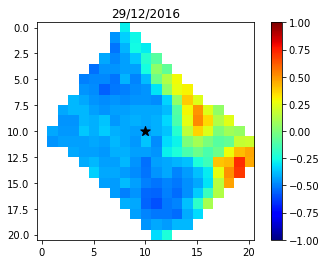

In [20]:
# Image
if check_results:

    fig = plt.figure()
    
    plt.imshow(img_mat_list[img_idx], cmap='jet', vmin=-1, vmax=1)
    
    plt.title(dates[img_idx].strftime("%d/%m/%Y"))
    
    plt.colorbar()
    plt.scatter(point[1], point[0], s=100, c='black', marker='*')
    
    #plt.savefig('ndvi_plot.png', dpi=300)
    
    plt.show()

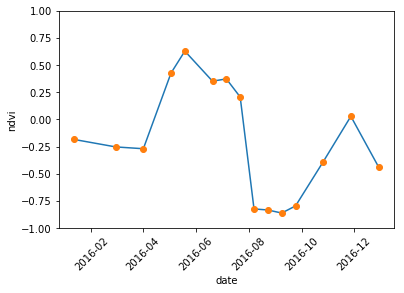

In [21]:
# Pixel time series
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in img_mat_list]
    
    fig = plt.figure()
    
    plt.plot(dates, ndvi_values, '-')
    plt.plot(dates, ndvi_values, 'o')
    
    #plt.vlines([datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0)], -1, 1, colors='b', linestyle='--')
    
    #plt.vlines([datetime.datetime(2014, 4, 1, 0, 0), datetime.datetime(2015, 4, 1, 0, 0), datetime.datetime(2016, 4, 1, 0, 0), datetime.datetime(2017, 4, 1, 0, 0)], -1, 1, colors='g', linestyle='--')
    #plt.vlines([datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 9, 1, 0, 0), datetime.datetime(2016, 9, 1, 0, 0), datetime.datetime(2017, 9, 1, 0, 0)], -1, 1, colors='r', linestyle='--')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_tm.png', dpi=300)
    plt.show()



#### Smooth and gap fill

In [22]:
if check_results:
    # filter ndvi TM of a pixel
    dates_inter, ndvi_inter = ndvi_filter (dates, ndvi_values)
    




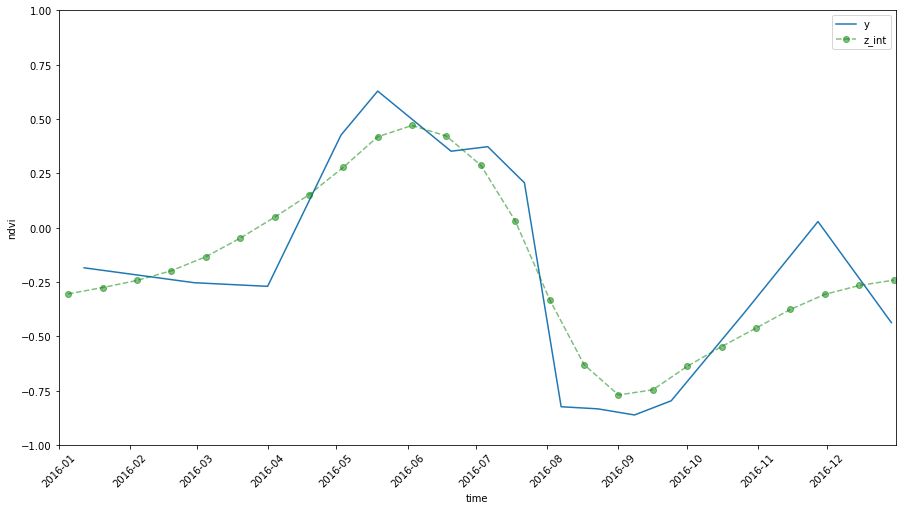

0.628187
-0.861286


In [23]:
if check_results:
    
    plt.figure(figsize=(15,8))
    plt.ylim(0,1)
    plt.plot(dates, ndvi_values, label='y')
    #plt.plot(xax1, z, 'rs', label='z', alpha=0.7)
    plt.plot(dates_inter, ndvi_inter, 'go--', label='z_int', alpha=0.5)

    plt.xticks(rotation=45)
    plt.xlabel('time')
    plt.ylabel('ndvi')
   
    plt.xlim((datetime.datetime(dates[0].year, 1, 1, 0, 0), datetime.datetime(dates[0].year, 12, 31, 0, 0)))
    plt.ylim((-1, 1))

    plt.legend()

    #plt.savefig('ndvi_' + str(dates[0].year) + '.png', dpi=300)

    plt.show()
    
    print(max(ndvi_values))
    print(min(ndvi_values))

In [24]:
# create an empty list of images to store interpolated ndvi data

ndvi_img_inter = []

# number of images -> 365 / 15
for i in range(25):
    ndvi_img_inter.append(np.full_like(img_mat_list[0].data, -9999.0))


In [25]:
# interpolate ndvi for each pixel
dates_inter = []

for i in range(img_mat_list[0].shape[0]):
    for j in range(img_mat_list[0].shape[1]):
        
        #print(i,j)
        
        # get ndvi time series for position i,j
        ndvi_tm = [img.data[i,j] for img in img_mat_list]
        
        # count number of no values
        n_novalue = ndvi_tm.count(-9999)
        
        
        if (n_novalue < len(img_mat_list)): # if it's not everything no value
            
            # swap no value for np.nan
            ndvi_tm = [np.nan if x < -9998 else x for x in ndvi_tm]
            
            # smooth and gap fill
            dates_inter, ndvi_inter = ndvi_filter (dates, ndvi_tm)

            if max(ndvi_tm) < 0.25: # remove non cultivated pixels
                print('the following pixel will be ignored:')
                print(i,j, max(ndvi_tm))
            
            else:
                # swap np.nan for -9999
                ndvi_inter[np.isnan(ndvi_inter)] = -9999.0
        
                # save new time series in position i,j
                for idx,ndvi_inter in enumerate(ndvi_inter):
                    ndvi_img_inter[idx][i,j] = ndvi_inter



# mask -9999 values
for idx in range(len(ndvi_img_inter)):
    
    ndvi_img_inter[idx] = ma.masked_values (ndvi_img_inter[idx], -9999.0)
        
        #print(ndvi_inter)
        


the following pixel will be ignored:
(1, 7, 0.05547563)
the following pixel will be ignored:
(1, 8, 0.059590235)
the following pixel will be ignored:
(2, 7, 0.055251703)
the following pixel will be ignored:
(2, 8, 0.056330655)
the following pixel will be ignored:
(2, 9, 0.14638999)
the following pixel will be ignored:
(3, 7, 0.1351375)
the following pixel will be ignored:
(3, 8, 0.20131208)
the following pixel will be ignored:
(3, 10, 0.21134163)
the following pixel will be ignored:
(4, 5, 0.093986504)
the following pixel will be ignored:
(5, 4, 0.017053353)
the following pixel will be ignored:
(5, 5, 0.1001007)
the following pixel will be ignored:
(6, 4, 0.066997021)
the following pixel will be ignored:
(7, 3, 0.10481503)
the following pixel will be ignored:
(8, 2, 0.056358952)
the following pixel will be ignored:
(8, 3, 0.18728366)
the following pixel will be ignored:
(9, 2, 0.18839033)
the following pixel will be ignored:
(10, 1, 0.15640624)
the following pixel will be ignored:
(12,

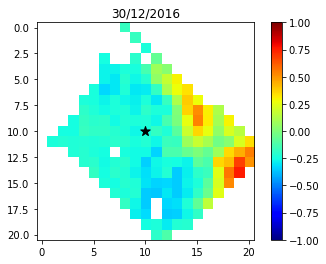

-0.106431486548


In [26]:
if check_results:
    
    #point = [10, 10]
    #point = [15, 10]


    #fig = plt.figure()
    #plt.imshow(img_mat_list[0])
    #plt.show()
    
    fig = plt.figure()
    
    img_idx = -1
    
    plt.imshow(ndvi_img_inter[img_idx], cmap='jet', vmin=-1, vmax=1)
    #plt.imshow(mx, cmap='jet', vmin=-1, vmax=1)
    
    plt.title(dates_inter[img_idx].strftime("%d/%m/%Y"))
    
    plt.colorbar()
    plt.scatter(point[1], point[0], s=100, c='black', marker='*')
    
    #plt.savefig('ndvi_plot.png', dpi=300)
    
    plt.show()
    
    print(ndvi_img_inter[img_idx].mean())

In [27]:

#np.percentile(ndvi_img_inter[img_idx].data[ndvi_img_inter[img_idx].data > -9998.0], 50)


In [28]:
#img_idx = -1

#Q1 = np.percentile(ndvi_img_inter[img_idx].data[ndvi_img_inter[img_idx].data > -9998.0], 25)
#Q3 = np.percentile(ndvi_img_inter[img_idx].data[ndvi_img_inter[img_idx].data > -9998.0], 75)

#IQR = Q3-Q1

#MinV = Q1 - 2.5 * IQR
#MaxV = Q3 + 2.5 * IQR

#print(Q1,Q3)

#print(MinV,MaxV)

In [29]:
#ndvi_img_inter[img_idx].data[ndvi_img_inter[img_idx].data > MaxV]


In [30]:
#ndvi_img_inter[img_idx].data[np.logical_or(ndvi_img_inter[img_idx].data > MaxV, ndvi_img_inter[img_idx].data > MaxV)]

In [31]:

# for each image find outliers based on IQR
# only for values greater then

mat_outliers = []
for idx in range(len(ndvi_img_inter)):
    
    
    Q1 = np.percentile(ndvi_img_inter[idx].data[ndvi_img_inter[idx].data > -9998.0], 25)
    Q3 = np.percentile(ndvi_img_inter[idx].data[ndvi_img_inter[idx].data > -9998.0], 75)

    IQR = Q3-Q1

    MinV = Q1 - 2.5 * IQR
    MaxV = Q3 + 2.5 * IQR
    
    if idx == 0:
        mat_outliers = ndvi_img_inter[idx].data > MaxV
        #mat_outliers = np.logical_or(ndvi_img_inter[idx].data > MaxV, ndvi_img_inter[idx].data < MinV)
        
    else:
        mat_outliers = np.logical_or(mat_outliers, ndvi_img_inter[idx].data > MaxV)
        #mat_outliers = np.logical_or(mat_outliers, np.logical_or(ndvi_img_inter[idx].data > MaxV, ndvi_img_inter[idx].data < MinV) )
    
    
ndvi_img_inter[img_idx].data[mat_outliers]



array([ 0.5179463 ,  0.54193956,  0.34502116,  0.55463785,  0.6815657 ,
        0.50358367,  0.56359953,  0.76461977,  0.21897103,  0.52589959,
       -0.18908548], dtype=float32)

In [32]:
# remove outliers from data
for idx in range(len(ndvi_img_inter)):
    
    ndvi_img_inter[idx] = ma.masked_array(ndvi_img_inter[idx], mask=mat_outliers)

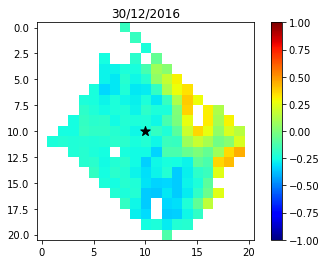

-0.138387385103


In [33]:
if check_results:
    
    #point = [10, 10]
    #point = [15, 10]


    #fig = plt.figure()
    #plt.imshow(img_mat_list[0])
    #plt.show()
    
    fig = plt.figure()
    
    img_idx = -1
    
    plt.imshow(ndvi_img_inter[img_idx], cmap='jet', vmin=-1, vmax=1)
    #plt.imshow(mx, cmap='jet', vmin=-1, vmax=1)
    
    plt.title(dates_inter[img_idx].strftime("%d/%m/%Y"))
    
    plt.colorbar()
    plt.scatter(point[1], point[0], s=100, c='black', marker='*')
    
    #plt.savefig('ndvi_plot.png', dpi=300)
    
    plt.show()
    
    print(ndvi_img_inter[img_idx].mean())

#### Remove non cultivated pixels II

In [34]:

mask_mat = np.full(img_mat_list[0].shape, False)

for i in range(ndvi_img_inter[0].shape[0]):
    for j in range(ndvi_img_inter[0].shape[1]):
        
        
        c_no_values = 0
        c_gt_v = 0
        
        for im in ndvi_img_inter:
            #if i == 10 and j == 10:
            
            if im[i,j] > 0.20:
                    
                c_gt_v = c_gt_v + 1
                    
                #print(im[i,j])
                
            if im.data[i,j] < -9998:
                
                c_no_values = c_no_values + 1
                    
        if c_gt_v == 0 and c_no_values != len(ndvi_img_inter):
            mask_mat[i,j] = True
            print(i,j)
        

(0, 8)
(1, 9)
(2, 10)
(3, 6)
(6, 5)
(7, 6)
(8, 15)
(9, 3)
(9, 15)
(10, 2)
(10, 3)
(10, 4)
(11, 1)
(11, 20)
(12, 6)
(12, 20)
(13, 7)
(13, 8)
(13, 19)
(13, 20)
(14, 8)
(14, 18)
(14, 19)
(15, 9)
(15, 17)
(15, 18)
(16, 11)
(16, 12)
(17, 12)
(20, 11)


In [35]:
for idx in range(len(ndvi_img_inter)):
    ndvi_img_inter[idx] = ma.masked_array(ndvi_img_inter[idx], mask=mask_mat)

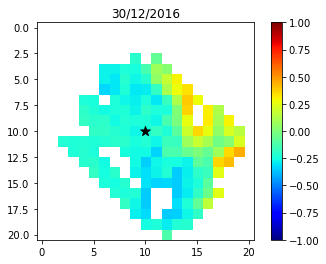

-0.12747743879


In [36]:
if check_results:
    
    #point = [10, 10]
    #point = [15, 10]


    #fig = plt.figure()
    #plt.imshow(img_mat_list[0])
    #plt.show()
    
    fig = plt.figure()
    
    img_idx = -1
    
    plt.imshow(ndvi_img_inter[img_idx], cmap='jet', vmin=-1, vmax=1)
    #plt.imshow(mx, cmap='jet', vmin=-1, vmax=1)
    
    plt.title(dates_inter[img_idx].strftime("%d/%m/%Y"))
    
    plt.colorbar()
    plt.scatter(point[1], point[0], s=100, c='black', marker='*')
    
    #plt.savefig('ndvi_plot.png', dpi=300)
    
    plt.show()
    
    print(ndvi_img_inter[img_idx].mean())

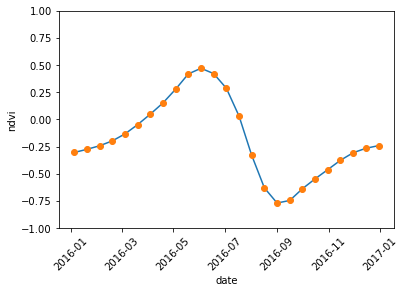

In [37]:
# get interpolated values for a given pixel

if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in ndvi_img_inter]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    
    ndvi_values = np.array(ndvi_values)
    dates_inter = np.array(dates_inter)

    
    #plt.vlines([datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0)], -1, 1, colors='b', linestyle='--')
    
    #plt.vlines([datetime.datetime(2014, 4, 1, 0, 0), datetime.datetime(2015, 4, 1, 0, 0), datetime.datetime(2016, 4, 1, 0, 0), datetime.datetime(2017, 4, 1, 0, 0)], -1, 1, colors='g', linestyle='--')
    #plt.vlines([datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 9, 1, 0, 0), datetime.datetime(2016, 9, 1, 0, 0), datetime.datetime(2017, 9, 1, 0, 0)], -1, 1, colors='r', linestyle='--')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    #plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_tm.png', dpi=300)
    plt.show()
    
    
    
    
    
    

#### Find start and end dates of growing season

In [38]:
#
# Input: ndvi time series and dates
# Output: start and end dates and ndvi values of growing season
#
def find_start_end_date_season(dates_ts, ndvi_ts):
    
    # max value position 
    maxp = int(np.where(ndvi_ts == np.amax(ndvi_ts))[0])
    
    peaks, _ = scipy.signal.find_peaks(ndvi_values, height=-1)
    maxp = peaks[0]
    
    #print(len(peaks))
    
    #if (maxp == 0):
    #    return start_season_date, start_season_ndvi, end_season_date, end_season_ndvi
    
    # start of season
        
    # first half
    x = [d.timetuple().tm_yday for d in dates_ts[0:maxp+1]]
    y = ndvi_ts[0:maxp+1]
    

    # choose best fit (linear, square, cubic)
    r2 = 0
    #p1 = None
    for d in [1,2]:
    
        coeffs_aux = np.polyfit(x=x, y=y, deg=d)
        p1_aux = np.poly1d(coeffs_aux)

        r2_aux = 1 - sum((y-p1_aux(x))**2) / sum((y-np.mean(y))**2)
    
        if r2_aux > r2:
            coeffs = coeffs_aux
            p1 = p1_aux
            r2 = r2_aux

    #if p1 is None:
    #    return -9999, -9999, -9999, -9999
            
    # derivative
    p2 = np.polyder(p1)
    
    
    for vp, vpd, d, ddate in zip(y,p2(x),x,dates_ts):
    
        #print(d, vpd, vp)
    
        # if derivative positive and ndvi value positive
        # get values and stop search
        if vpd > 0 and vp > 0:
        
            #print(d, vpd, vp)
        
            start_season_ndvi = vp
            start_season_date = ddate
        
            break
            
    #plt.figure()
    #plt.plot(x, p1(x))
    #plt.plot(x, p2(x))

    # END OF SEASON
    
    x = [d.timetuple().tm_yday for d in dates_ts[maxp:]]
    y = ndvi_ts[maxp:]
    
    
    #x_fliped = np.flip(x, axis=None)
    #y_fliped = np.flip(y, axis=None)
    
    x_fliped = x[::-1]
    y_fliped = y[::-1]

    # choose best fit
    r2 = 0
    #p1 = None
    for d in [1,2]:
    
        coeffs_aux = np.polyfit(x=x, y=y_fliped, deg=d)
        p1_aux = np.poly1d(coeffs_aux)

        r2_aux = 1 - sum((y_fliped-p1_aux(x))**2) / sum((y_fliped-np.mean(y_fliped))**2)
    
        if r2_aux > r2:
            coeffs = coeffs_aux
            p1 = p1_aux
            r2 = r2_aux

    # derivative
    p2 = np.polyder(p1)
    
    idx = 0
    idx_fliped = 0
    for vp, vpd, d, d_f in zip(y_fliped,p2(x),x,x_fliped):
    
        #print(d, vpd, vp)
        
        #print(p1(x))
        
        # if derivative positive and ndvi value positive
        # get values and stop search
        if vpd > 0 and vp > 0:
        
            #print(d, vpd, vp)
        
            d = d_f
            
            idx_fliped = idx
            
            break
            
        idx = idx + 1
    
    
    
        

    idx_end = len(dates_ts) - (idx_fliped+1)
        
    end_season_date = dates_ts[idx_end]
    end_season_ndvi = ndvi_ts[idx_end]

    
    #plt.plot(x, y, 'o')
    #plt.plot(d, vp, 's')
    #plt.figure()
    #plt.plot(x, p1(x))
    #plt.plot(x, p2(x))
    
    #print('poly')
    #print(p1)
    #print('derivative')
    #print(p2(x))
    #print('r2')


    #print(idx_end)

    
    return start_season_date, start_season_ndvi, end_season_date, end_season_ndvi


#print(start_season_date.strftime("%Y%j"), start_season_ndvi)
#print(end_season_date.strftime("%Y%j"), end_season_ndvi)

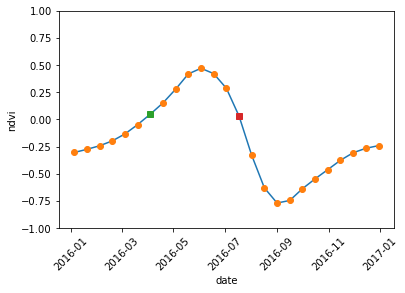

In [39]:
# get start and end date for a give pixel TS
if check_results:
    
    
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in ndvi_img_inter]
    
    
    start_season_date, start_season_ndvi, end_season_date, end_season_ndvi = find_start_end_date_season(dates_inter, ndvi_values)
    
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    plt.plot(start_season_date, start_season_ndvi, 's')
    plt.plot(end_season_date, end_season_ndvi, 's')
    
    ndvi_values = np.array(ndvi_values)
    dates_inter = np.array(dates_inter)

    
    #plt.vlines([datetime.datetime(2014, 1, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0)], -1, 1, colors='b', linestyle='--')
    
    #plt.vlines([datetime.datetime(2014, 4, 1, 0, 0), datetime.datetime(2015, 4, 1, 0, 0), datetime.datetime(2016, 4, 1, 0, 0), datetime.datetime(2017, 4, 1, 0, 0)], -1, 1, colors='g', linestyle='--')
    #plt.vlines([datetime.datetime(2014, 9, 1, 0, 0), datetime.datetime(2015, 9, 1, 0, 0), datetime.datetime(2016, 9, 1, 0, 0), datetime.datetime(2017, 9, 1, 0, 0)], -1, 1, colors='r', linestyle='--')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    #plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_tm.png', dpi=300)
    plt.show()

In [40]:
# compute start and end dates of growing season for all images

start_date_img = np.full_like(ndvi_img_inter[0].data, -9999.0)
end_date_img = np.full_like(ndvi_img_inter[0].data, -9999.0)

for i in range(ndvi_img_inter[0].shape[0]):
    for j in range(ndvi_img_inter[0].shape[1]):
        
        ndvi_tm = ma.array([img[i,j] for img in ndvi_img_inter])
        
        if (ndvi_tm.count() > 0):
            
            #print(i,j)
            
            start_season_date, start_season_ndvi, end_season_date, end_season_ndvi = find_start_end_date_season(dates_inter, ndvi_tm)
            
            start_date_img[i,j] = start_season_date.strftime("%Y%j")
            end_date_img[i,j] = end_season_date.strftime("%Y%j")

/opt/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


#### Check start and end dates of growing season

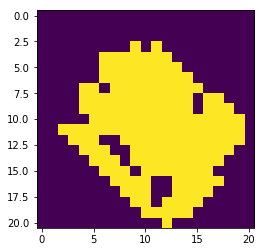

numpy.ndarray

In [41]:
if check_results:
    
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(end_date_img)
    
    plt.show()
    
type(end_date_img)

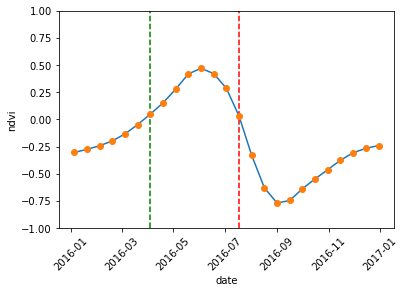

In [42]:
# check results for a given pixel
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in ndvi_img_inter]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    #plt.plot( datetime.datetime.strptime(str(int(end_date_img[point[0], point[1]])), '%Y%j'), 0, 's')
    #plt.plot( datetime.datetime.strptime(str(int(start_date_img[point[0], point[1]])), '%Y%j'), 0, 's')
    
    start_date_px = datetime.datetime.strptime(str(int(start_date_img[point[0], point[1]])), '%Y%j')
    end_date_px = datetime.datetime.strptime(str(int(end_date_img[point[0], point[1]])), '%Y%j')
    
    plt.vlines([start_date_px], -1, 1, colors='g', linestyle='--')
    plt.vlines([end_date_px], -1, 1, colors='r', linestyle='--')
    
    
    ndvi_values = np.array(ndvi_values)
    dates_inter = np.array(dates_inter)

   
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    #plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_tm.png', dpi=300)
    plt.show()

#### Get NDVI differences

In [43]:
def get_ndvi_diffs (matrix_img_list):
    
    # get mask from first image
    mask_mat = matrix_img_list[0].mask
    
    dif_matrix_img_list = []
    for i in range(len(matrix_img_list) - 1):
        
        diff = matrix_img_list[i+1] - matrix_img_list[i]
        
        diff = ma.masked_array(diff, mask=mask_mat)
        
        dif_matrix_img_list.append(diff)
        
    return dif_matrix_img_list
        
dif_matrix_img_list = get_ndvi_diffs (ndvi_img_inter)

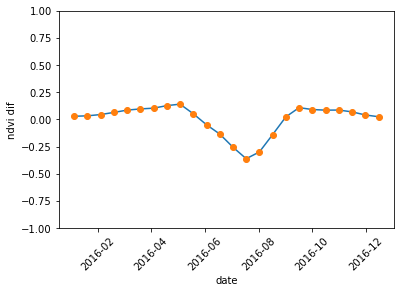

In [44]:
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in dif_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates_inter[:-1], ndvi_values, '-')
    plt.plot(dates_inter[:-1], ndvi_values, 'o')
    
    plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('ndvi dif')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()

Cumulative NDVI value for growing season

In [45]:
def get_ndvi_cumulative (matrix_img_list):
    
    cumulative_matrix_img_list = []
    
    # get mask from first image
    mask_mat = matrix_img_list[0].mask
    
    cum_ndvi = []
    for idx,img_ndvi in enumerate(matrix_img_list):
        
        if idx == 0:
            cum_ndvi = img_ndvi
        else:
            cum_ndvi = cum_ndvi + img_ndvi
        
        cum_ndvi = ma.masked_array(cum_ndvi, mask=mask_mat)
        
        cumulative_matrix_img_list.append(cum_ndvi)
        
    return cumulative_matrix_img_list
        
cumulative_matrix_img_list = get_ndvi_cumulative (ndvi_img_inter)

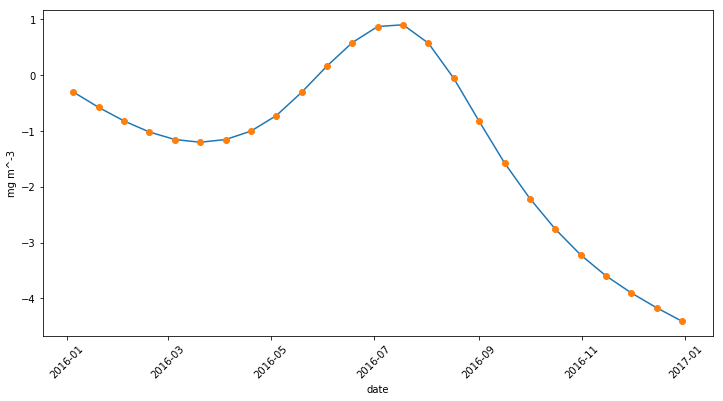

In [46]:
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()

Cumulative NDVI value for growing season

In [47]:
'''
def get_inverse_ndvi_cumulative (matrix_img_list):
    
    inv_cumulative_matrix_img_list = []
    
    inv_cum_ndvi = []
    for idx,img_ndvi in enumerate(reversed(matrix_img_list)):
        
        
        
        if idx == 0:
            inv_cum_ndvi = img_ndvi
        else:
            inv_cum_ndvi = inv_cum_ndvi + img_ndvi
            
        
        
        inv_cumulative_matrix_img_list.append(inv_cum_ndvi)
        
    return list(reversed(inv_cumulative_matrix_img_list))
        
inv_cumulative_matrix_img_list = get_inverse_ndvi_cumulative (ndvi_img_inter)
'''

'\ndef get_inverse_ndvi_cumulative (matrix_img_list):\n    \n    inv_cumulative_matrix_img_list = []\n    \n    inv_cum_ndvi = []\n    for idx,img_ndvi in enumerate(reversed(matrix_img_list)):\n        \n        \n        \n        if idx == 0:\n            inv_cum_ndvi = img_ndvi\n        else:\n            inv_cum_ndvi = inv_cum_ndvi + img_ndvi\n            \n        \n        \n        inv_cumulative_matrix_img_list.append(inv_cum_ndvi)\n        \n    return list(reversed(inv_cumulative_matrix_img_list))\n        \ninv_cumulative_matrix_img_list = get_inverse_ndvi_cumulative (ndvi_img_inter)\n'

In [48]:
'''
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()
    
    print(ndvi_values)
'''

'\nif check_results:\n    \n    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]\n    \n    fig = plt.figure()\n    \n    plt.plot(dates_inter, ndvi_values, \'-\')\n    plt.plot(dates_inter, ndvi_values, \'o\')\n    \n    #plt.ylim((-1, 1))\n    #plt.set_xlim([0, 5])\n\n    plt.xticks(rotation=45)\n    plt.xlabel(\'date\')\n    plt.ylabel(\'mg m^-3\')\n    #plt.title(\'Chlorophyll-a concentration (percentile 90)\nAzores (\' + str_area_title + \')\')\n    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)\n\n    #plt.savefig(\'ndvi_graph.png\', dpi=300)\n    plt.show()\n    \n    print(ndvi_values)\n'

In [49]:
'''
if check_results:
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]
    
    fig = plt.figure()
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    
    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]
    
    
    
    plt.plot(dates_inter, ndvi_values, '-')
    plt.plot(dates_inter, ndvi_values, 'o')
    
    #plt.ylim((-1, 1))
    #plt.set_xlim([0, 5])

    plt.xticks(rotation=45)
    plt.xlabel('date')
    plt.ylabel('mg m^-3')
    #plt.title('Chlorophyll-a concentration (percentile 90)\nAzores (' + str_area_title + ')')
    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

    #plt.savefig('ndvi_graph.png', dpi=300)
    plt.show()
    
    print(ndvi_values)
    
'''

'\nif check_results:\n    \n    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in inv_cumulative_matrix_img_list]\n    \n    fig = plt.figure()\n    \n    plt.plot(dates_inter, ndvi_values, \'-\')\n    plt.plot(dates_inter, ndvi_values, \'o\')\n    \n    \n    ndvi_values = [ndvi_img[point[0], point[1]] for ndvi_img in cumulative_matrix_img_list]\n    \n    \n    \n    plt.plot(dates_inter, ndvi_values, \'-\')\n    plt.plot(dates_inter, ndvi_values, \'o\')\n    \n    #plt.ylim((-1, 1))\n    #plt.set_xlim([0, 5])\n\n    plt.xticks(rotation=45)\n    plt.xlabel(\'date\')\n    plt.ylabel(\'mg m^-3\')\n    #plt.title(\'Chlorophyll-a concentration (percentile 90)\nAzores (\' + str_area_title + \')\')\n    plt.rcParams["figure.figsize"] = (12, 6) # (w, h)\n\n    #plt.savefig(\'ndvi_graph.png\', dpi=300)\n    plt.show()\n    \n    print(ndvi_values)\n    \n'

NDVI peak value

In [50]:
def get_ndvi_peak (matrix_img_list):

    # get mask from first image
    mask_mat = matrix_img_list[0].mask
    
    peak_ndvi = []
    for idx,img_ndvi in enumerate(matrix_img_list):
        if idx == 0:
            peak_ndvi = img_ndvi
        else:
            peak_ndvi = np.where(peak_ndvi < img_ndvi, img_ndvi, peak_ndvi)
        
    peak_ndvi = ma.masked_array(peak_ndvi, mask=mask_mat)
        
    return peak_ndvi
        
peak_matrix_img = get_ndvi_peak (ndvi_img_inter)

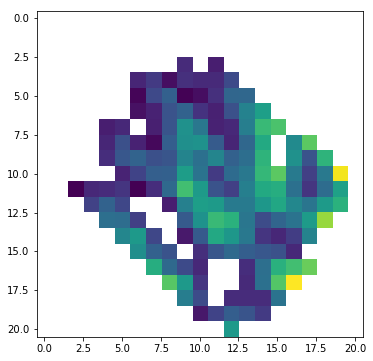

0.898779
0.205325


In [51]:
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(peak_matrix_img)
    
    plt.show()
    
    print(peak_matrix_img.max())
    print(peak_matrix_img.min())

#### Mask -9999 values

In [103]:
start_date_img_ma = ma.masked_array(start_date_img, mask = start_date_img < -9998, fill_value=-9999)

type(start_date_img_ma)

numpy.ma.core.MaskedArray

In [104]:
end_date_img_ma = ma.masked_array(end_date_img, mask = end_date_img < -9998, fill_value=-9999)

type(end_date_img_ma)

numpy.ma.core.MaskedArray

In [105]:
type(dif_matrix_img_list[0])

numpy.ma.core.MaskedArray

In [106]:
type(cumulative_matrix_img_list[0])

numpy.ma.core.MaskedArray

In [107]:
peak_matrix_img_ma = ma.masked_array(peak_matrix_img, mask = end_date_img < -9998)

type(peak_matrix_img_ma[0])

numpy.ma.core.MaskedArray

## Per Parcel

In [108]:
#start_date_img_ma.mean()

col_names = ['start_date', 'end_date', 'start_growing_season']
start_date_parcel = pd.DataFrame(columns=col_names)
start_date_parcel = start_date_parcel.append({'start_date': dates_inter[0], 'end_date': dates_inter[-1], 'start_growing_season': int(start_date_img_ma.mean())}, ignore_index=True)

start_date_parcel

,start_date,end_date,start_growing_season
0,2016-01-05,2016-12-30,2016098


In [109]:
#end_date_img_ma.mean()

col_names = ['start_date', 'end_date', 'end_growing_season']
end_date_parcel = pd.DataFrame(columns=col_names)
end_date_parcel = end_date_parcel.append({'start_date': dates_inter[0], 'end_date': dates_inter[-1], 'end_growing_season': int(end_date_img_ma.mean())}, ignore_index=True)

end_date_parcel

,start_date,end_date,end_growing_season
0,2016-01-05,2016-12-30,2016194


In [110]:
#[mat.mean() for mat in dif_matrix_img_list]

col_names = ['start_date', 'end_date', 'dif_ndvi']
dif_ndvi_parcel = pd.DataFrame(columns=col_names)

for idx in range(len(dates_inter)-1):
    
    dif_ndvi_parcel = dif_ndvi_parcel.append({'start_date': dates_inter[idx], 'end_date': dates_inter[idx+1], 'dif_ndvi': dif_matrix_img_list[idx].mean()}, ignore_index=True)

dif_ndvi_parcel

,start_date,end_date,dif_ndvi
0,2016-01-05,2016-01-20,0.038123
1,2016-01-20,2016-02-04,0.039724
2,2016-02-04,2016-02-19,0.044502
3,2016-02-19,2016-03-05,0.052530
4,2016-03-05,2016-03-20,0.062837
5,2016-03-20,2016-04-04,0.073629
6,2016-04-04,2016-04-19,0.089985
7,2016-04-19,2016-05-04,0.126181
8,2016-05-04,2016-05-19,0.152853
9,2016-05-19,2016-06-03,0.069335


In [111]:
#[mat.mean() for mat in cumulative_matrix_img_list]

col_names = ['start_date', 'end_date', 'cumulative_ndvi']
cumulative_ndvi_parcel = pd.DataFrame(columns=col_names)

for idx in range(len(dates_inter)):
    
    cumulative_ndvi_parcel = cumulative_ndvi_parcel.append({'start_date': dates_inter[0], 'end_date': dates_inter[idx], 'cumulative_ndvi': cumulative_matrix_img_list[idx].mean()}, ignore_index=True)

cumulative_ndvi_parcel

,start_date,end_date,cumulative_ndvi
0,2016-01-05,2016-01-05,-0.324062
1,2016-01-05,2016-01-20,-0.610000
2,2016-01-05,2016-02-04,-0.856215
3,2016-01-05,2016-02-19,-1.057927
4,2016-01-05,2016-03-05,-1.207109
5,2016-01-05,2016-03-20,-1.293455
6,2016-01-05,2016-04-04,-1.306171
7,2016-01-05,2016-04-19,-1.228902
8,2016-01-05,2016-05-04,-1.025452
9,2016-01-05,2016-05-19,-0.669149


In [112]:
#peak_matrix_img_ma.mean()

col_names = ['start_date', 'end_date', 'peak_ndvi']
peak_ndvi_parcel = pd.DataFrame(columns=col_names)
peak_ndvi_parcel = peak_ndvi_parcel.append({'start_date': dates_inter[0], 'end_date': dates_inter[-1], 'peak_ndvi': peak_matrix_img_ma.mean()}, ignore_index=True)

peak_ndvi_parcel

,start_date,end_date,peak_ndvi
0,2016-01-05,2016-12-30,0.43896


#### Export results

In [113]:
# get metada data
projection, geotransform, no_data_value, data_type = get_metadata(file_list[0])

first_part = os.path.basename(file_list[0])[0:4]
areaOfInterestName = nameOfRegion['value']

##### Export to excel

In [114]:
var_name = 'ndviStats'

start_date = dates_inter[0]
end_date = dates_inter[-1]

excel_output_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.xlsx'
    
excel_output_name = os.path.join(output_folder, excel_output_name)

print(excel_output_name)

with pd.ExcelWriter(excel_output_name) as writer:  # doctest: +SKIP
    start_date_parcel.to_excel(writer, sheet_name='start_growing_season')
    end_date_parcel.to_excel(writer, sheet_name='end_growing_season')
    dif_ndvi_parcel.to_excel(writer, sheet_name='dif_ndvi')
    cumulative_ndvi_parcel.to_excel(writer, sheet_name='cumulative_ndvi')
    peak_ndvi_parcel.to_excel(writer, sheet_name='peak_ndvi')


LE07_ndviStats_P001_2016005_2016365.xlsx


difference ndvi

In [115]:

var_name = 'difNdvi'

for idx in range(len(dif_ndvi_parcel)):
    
    print(dif_ndvi_parcel['start_date'][idx])
    
    start_date = dif_ndvi_parcel['start_date'][idx]
    end_date = dif_ndvi_parcel['end_date'][idx]
    
    dif_matrix_img = dif_matrix_img_list[idx]
    
    dif_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
    dif_ndvi_img_name = os.path.join(output_folder, dif_ndvi_img_name)
    
    print(dif_ndvi_img_name)
    
    write_output_image(dif_ndvi_img_name, dif_matrix_img, 'GTiff', data_type, None, projection, geotransform, no_data_value)
    
    write_properties_file(dif_ndvi_img_name, start_date, end_date, regionOfInterest['value'])


2016-01-05
LE07_difNdvi_P001_2016005_2016020.tif
2016-01-20
LE07_difNdvi_P001_2016020_2016035.tif
2016-02-04
LE07_difNdvi_P001_2016035_2016050.tif
2016-02-19
LE07_difNdvi_P001_2016050_2016065.tif
2016-03-05
LE07_difNdvi_P001_2016065_2016080.tif
2016-03-20
LE07_difNdvi_P001_2016080_2016095.tif
2016-04-04
LE07_difNdvi_P001_2016095_2016110.tif
2016-04-19
LE07_difNdvi_P001_2016110_2016125.tif
2016-05-04
LE07_difNdvi_P001_2016125_2016140.tif
2016-05-19
LE07_difNdvi_P001_2016140_2016155.tif
2016-06-03
LE07_difNdvi_P001_2016155_2016170.tif
2016-06-18
LE07_difNdvi_P001_2016170_2016185.tif
2016-07-03
LE07_difNdvi_P001_2016185_2016200.tif
2016-07-18
LE07_difNdvi_P001_2016200_2016215.tif
2016-08-02
LE07_difNdvi_P001_2016215_2016230.tif
2016-08-17
LE07_difNdvi_P001_2016230_2016245.tif
2016-09-01
LE07_difNdvi_P001_2016245_2016260.tif
2016-09-16
LE07_difNdvi_P001_2016260_2016275.tif
2016-10-01
LE07_difNdvi_P001_2016275_2016290.tif
2016-10-16
LE07_difNdvi_P001_2016290_2016305.tif
2016-10-31
LE07_difN

Cumulative ndvi

In [116]:
var_name = 'cumulativeNdvi'

for idx in range(len(cumulative_ndvi_parcel)):
    
    print(cumulative_ndvi_parcel['start_date'][idx])
    
    start_date = cumulative_ndvi_parcel['start_date'][idx]
    end_date = cumulative_ndvi_parcel['end_date'][idx]
    
    cum_matrix_img = cumulative_matrix_img_list[idx]
    
    cum_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
    cum_ndvi_img_name = os.path.join(output_folder, cum_ndvi_img_name)
    
    print(cum_ndvi_img_name)
    
    write_output_image(cum_ndvi_img_name, cum_matrix_img, 'GTiff', data_type, None, projection, geotransform, no_data_value)
    
    write_properties_file(cum_ndvi_img_name, start_date, end_date, regionOfInterest['value'])

2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016005.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016020.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016035.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016050.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016065.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016080.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016095.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016110.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016125.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016140.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016155.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016170.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016185.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016200.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016215.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016230.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016245.tif
2016-01-05
LE07_cumulativeNdvi_P001_2016005_2016

Peak value

In [117]:
#peak_matrix_img_ma
#peak_ndvi_parcel

var_name = 'ndviPeak'

start_date = peak_ndvi_parcel['start_date'][0]
end_date = peak_ndvi_parcel['end_date'][0]

peak_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
peak_ndvi_img_name = os.path.join(output_folder, peak_ndvi_img_name)
    
print(peak_ndvi_img_name)

write_output_image(peak_ndvi_img_name, peak_matrix_img, 'GTiff', data_type, None, projection, geotransform, no_data_value)

write_properties_file(peak_ndvi_img_name, start_date, end_date, regionOfInterest['value'])

LE07_ndviPeak_P001_2016005_2016365.tif


start growing season date

In [118]:
#start_date_img_ma
#start_date_parcel

var_name = 'startSeasonNdvi'

start_date = start_date_parcel['start_date'][0]
end_date = start_date_parcel['end_date'][0]

start_date_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
start_date_ndvi_img_name = os.path.join(output_folder, start_date_ndvi_img_name)
    
print(start_date_ndvi_img_name)

write_output_image(start_date_ndvi_img_name, start_date_img_ma, 'GTiff', gdal.GDT_Int32, None, projection, geotransform, no_data_value)

write_properties_file(start_date_ndvi_img_name, start_date, end_date, regionOfInterest['value'])

LE07_startSeasonNdvi_P001_2016005_2016365.tif


end growing season date

In [119]:
#end_date_img_ma
#end_date_parcel

var_name = 'endSeasonNdvi'

start_date = end_date_parcel['start_date'][0]
end_date = end_date_parcel['end_date'][0]

end_date_ndvi_img_name = '_'.join([first_part, var_name, areaOfInterestName, start_date.strftime("%Y%j"), end_date.strftime("%Y%j")]) + '.tif'
    
end_date_ndvi_img_name = os.path.join(output_folder, end_date_ndvi_img_name)
    
print(end_date_ndvi_img_name)

write_output_image(end_date_ndvi_img_name, end_date_img_ma, 'GTiff', gdal.GDT_Int32, None, projection, geotransform, no_data_value)

write_properties_file(end_date_ndvi_img_name, start_date, end_date, regionOfInterest['value'])

LE07_endSeasonNdvi_P001_2016005_2016365.tif


#### Remove temporay files and folders

In [ ]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)